# Lab 4, Day 2: Linear vs. Deep MLP on the Sonar Dataset
## COMP 395 – Deep Learning

**Goal:** Explore how MLP architecture choices affect performance on a real classification task.

**What you'll do:**
1. Load and explore the Sonar dataset (mines vs. rocks)
2. Build and train a **linear classifier** (baseline)
3. Design and train **your own MLP** architecture
4. Run **at least 5 architecture experiments**, logged to MLflow
5. Compare against a **Random Forest** baseline
6. Pull your MLflow data and write an **experiment report** with research-backed analysis


---
## Part 0: Setup and Imports


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up MLflow experiment
mlflow.set_experiment("lab4-sonar-classification")
print("Setup complete! MLflow experiment: lab4-sonar-classification")


2026/02/26 16:35:52 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/26 16:35:52 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/26 16:35:52 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/26 16:35:52 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/26 16:35:52 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/26 16:35:52 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/26 16:35:53 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/26 16:35:53 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Setup complete! MLflow experiment: lab4-sonar-classification


---
## Part 1: Load and Explore the Sonar Dataset

The Sonar dataset contains 208 samples of sonar signals bounced off either metal cylinders (mines) or rocks. Each sample has **60 features** representing energy at different frequency bands.

The task: classify whether a sonar return is from a **Mine** or a **Rock**.


In [2]:
# Load the Sonar dataset from UCI repository
# The data is available as a CSV with no header
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv"

try:
    df = pd.read_csv(url, header=None)
except:
    # Fallback: load from local file if no internet
    print("Could not download. Please download sonar.csv manually.")
    raise

# Last column is the label: 'M' for Mine, 'R' for Rock
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df.iloc[:, -1].value_counts())
print(f"\nFirst 5 rows (showing first 6 features + label):")
df.iloc[:, list(range(6)) + [-1]].head()


Dataset shape: (208, 61)

Class distribution:
60
M    111
R     97
Name: count, dtype: int64

First 5 rows (showing first 6 features + label):


,0,1,2,3,4,5,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,R


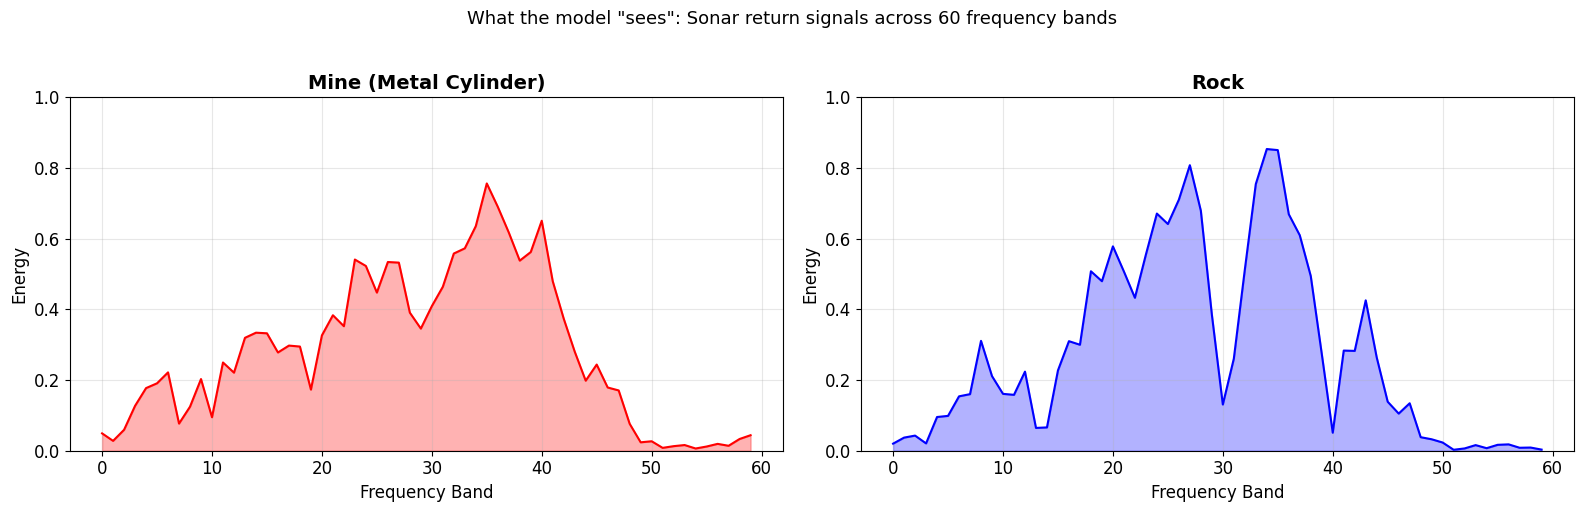

Each sample is a vector of 60 energy readings — this is the input to our classifier.
Can YOU spot the difference? That's what the model has to learn.


In [3]:
# Visualize what a Mine vs Rock "looks like" in sonar data
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Pick one example of each class
mine_sample = df[df.iloc[:, -1] == 'M'].iloc[0, :-1].values.astype(float)
rock_sample = df[df.iloc[:, -1] == 'R'].iloc[0, :-1].values.astype(float)

axes[0].plot(range(60), mine_sample, color='red', linewidth=1.5)
axes[0].fill_between(range(60), mine_sample, alpha=0.3, color='red')
axes[0].set_title('Mine (Metal Cylinder)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency Band')
axes[0].set_ylabel('Energy')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(60), rock_sample, color='blue', linewidth=1.5)
axes[1].fill_between(range(60), rock_sample, alpha=0.3, color='blue')
axes[1].set_title('Rock', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency Band')
axes[1].set_ylabel('Energy')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

plt.suptitle('What the model "sees": Sonar return signals across 60 frequency bands',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print("Each sample is a vector of 60 energy readings — this is the input to our classifier.")
print("Can YOU spot the difference? That's what the model has to learn.")


### ✏️ Think-Pair-Share: Understanding the Data

1. How many features does each sample have? How does this compare to the breast cancer dataset (30 features)?
60 features

2. Is the dataset balanced (roughly equal number of mines and rocks)?
roughly, its 111 vs 97

3. With 208 samples and 60 features, what concerns might you have about overfitting?
maybe too many features with too little samples will make it harder to learn each features contribution?


In [4]:
# Prepare the data for PyTorch
X = df.iloc[:, :-1].values.astype(np.float32)
y = (df.iloc[:, -1] == 'M').values.astype(np.float32)  # Mine=1, Rock=0

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize using ONLY training statistics (remember Assignment 3!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"Training samples: {X_train_t.shape[0]}")
print(f"Test samples:     {X_test_t.shape[0]}")
print(f"Features:         {X_train_t.shape[1]}")


Training samples: 166
Test samples:     42
Features:         60


---
## Part 2: Linear Classifier (Baseline)

First, let's build the simplest possible model: a single linear layer followed by sigmoid. This is essentially what you built in Assignment 3, but now using `nn.Module`.

### TODO: Define the Linear Model

Fill in the model definition below:


In [5]:
class LinearClassifier(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        # TODO: Define a single linear layer that maps n_features -> 1
        # Then apply sigmoid in the forward pass

        
        self.linear = nn.Linear(n_features, 1)
        
    
    def forward(self, x):
        # TODO: Pass x through the linear layer, then apply sigmoid
        return torch.sigmoid(self.linear(x))

# Create the model
linear_model = LinearClassifier(n_features=60)
print(linear_model)
print(f"\nTotal parameters: {sum(p.numel() for p in linear_model.parameters())}")


LinearClassifier(
  (linear): Linear(in_features=60, out_features=1, bias=True)
)

Total parameters: 61


### TODO: Write the Training Function

This training function will be reused for both models. Note the key differences from Assignment 3:
- We use `nn.BCELoss()` instead of MSE
- We use `loss.backward()` instead of manually computing gradients
- We process the **full batch** each step (not one sample at a time — the dataset is small enough)
- **Every run is automatically logged to MLflow** — parameters, metrics per epoch, and the final model. You'll use this data in Part 8 to build your experiment report.


In [6]:
def train_model(model, X_train, y_train, X_test, y_test, 
                n_epochs=200, lr=0.01, model_name="Model",
                architecture="", activation="", log_to_mlflow=True):
    """
    Train a binary classifier and record metrics.
    Automatically logs to MLflow when log_to_mlflow=True.
    
    Returns:
        dict with 'train_losses', 'test_losses', 'train_accs', 'test_accs'
    """
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_losses': [], 'test_losses': [],
        'train_accs': [], 'test_accs': []
    }
    
    # Start MLflow run
    run_context = mlflow.start_run(run_name=model_name) if log_to_mlflow else None
    
    if log_to_mlflow:
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("architecture", architecture)
        mlflow.log_param("activation", activation)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("n_epochs", n_epochs)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("loss_fn", "BCELoss")
        mlflow.log_param("n_parameters", sum(p.numel() for p in model.parameters()))
    
    for epoch in range(n_epochs):
        # --- Training step ---
        model.train()
        optimizer.zero_grad()
        
        # TODO: Forward pass on training data
        y_hat_train = model(X_train)
        
        # TODO: Compute BCE loss
        train_loss = criterion(y_hat_train, y_train)
        
        # TODO: Backward pass and optimizer step
        train_loss.backward()
        optimizer.step()
        
        # --- Evaluation (no gradients needed) ---
        model.eval()
        with torch.no_grad():
            y_hat_test = model(X_test)
            test_loss = criterion(y_hat_test, y_test)
            
            train_acc = ((y_hat_train >= 0.5) == y_train).float().mean().item()
            test_acc = ((y_hat_test >= 0.5) == y_test).float().mean().item()
        
        history['train_losses'].append(train_loss.item())
        history['test_losses'].append(test_loss.item())
        history['train_accs'].append(train_acc)
        history['test_accs'].append(test_acc)
        
        # Log metrics to MLflow every epoch
        if log_to_mlflow:
            mlflow.log_metric("train_loss", train_loss.item(), step=epoch)
            mlflow.log_metric("test_loss", test_loss.item(), step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
        
        if epoch % 50 == 0 or epoch == n_epochs - 1:
            print(f"[{model_name}] Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss.item():.4f} | "
                  f"Test Acc: {test_acc:.4f}")
    
    # Log final metrics and model
    if log_to_mlflow:
        mlflow.log_metric("final_train_acc", train_acc)
        mlflow.log_metric("final_test_acc", test_acc)
        mlflow.pytorch.log_model(model, "model")
        mlflow.end_run()
    
    return history


In [7]:
# Train the linear model
torch.manual_seed(42)
linear_model = LinearClassifier(n_features=60)
linear_history = train_model(
    linear_model, X_train_t, y_train_t, X_test_t, y_test_t,
    n_epochs=300, lr=0.01, model_name="Linear",
    architecture="60-1", activation="sigmoid"
)

print(f"\nFinal test accuracy: {linear_history['test_accs'][-1]:.4f}")


[Linear] Epoch   0 | Train Loss: 0.6804 | Test Acc: 0.6190
[Linear] Epoch  50 | Train Loss: 0.3080 | Test Acc: 0.8095
[Linear] Epoch 100 | Train Loss: 0.2600 | Test Acc: 0.8095
[Linear] Epoch 150 | Train Loss: 0.2320 | Test Acc: 0.8333
[Linear] Epoch 200 | Train Loss: 0.2119 | Test Acc: 0.8333
[Linear] Epoch 250 | Train Loss: 0.1965 | Test Acc: 0.8333


2026/02/26 16:36:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[Linear] Epoch 299 | Train Loss: 0.1842 | Test Acc: 0.8333


2026/02/26 16:36:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/26 16:36:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0.dev20241112+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.6.0.dev20241112' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/26 16:37:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0.dev20241112+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.6.0.dev2024


Final test accuracy: 0.8333


---
## Part 3: Your MLP

Now it's your turn to design a multi-layer perceptron. You know three things from the Day 1 theory:
- Nonlinear activations (ReLU) between layers prevent depth from collapsing
- Sigmoid on the output layer gives you a probability for binary classification
- BCELoss is the right loss function for this task

**Your job:** Design an MLP architecture that outperforms the linear baseline. You'll need to make decisions about:
- How many hidden layers?
- How many neurons in each layer?
- What activation function(s)?

There is no single "right" answer. Start with something reasonable, train it, and then iterate in Part 4.

### TODO: Define your first MLP architecture


In [10]:
class MLP(nn.Module):
    # TODO: Design your MLP
    # 
    # Things to decide:
    #   - How many hidden layers? (1? 2? 3?)
    #   - How wide? (8 neurons? 64? 256?)
    #   - What goes between layers?
    #
    # YOUR CODE HERE
    def __init__(self, n_features):
        super().__init__()
        # TODO: Define a single linear layer that maps n_features -> 1
        # Then apply sigmoid in the forward pass
        self.linear1 = nn.Linear(n_features, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, 1)
        
    
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.relu(x)
        x = self.linear4(x)
        x = torch.sigmoid(x)

        # TODO: Pass x through the linear layer, then apply sigmoid
        return x

# Create the model
mlp = MLP(n_features=60)
print(mlp)
    


MLP(
  (linear1): Linear(in_features=60, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)


### ✏️ Think-Pair-Share: Design Decisions

Before training, discuss with a partner:
1. How did you decide on your architecture? What was your reasoning?
looked online and it seems like the standard is to go from 64 to 32 to 1, mayber because of memory and bits or something, i did 64 to 32 to 16 to 1. I also considered the number of features and ideally wanted there to be more neurons on the first output layer than the number of features.

2. How many total parameters does your model have? (Run `sum(p.numel() for p in model.parameters())` to check.)

6529 parameters 

3. We have ~166 training samples. Does your parameter count concern you? Why or why not?

maybe? im not sure since i dont really have an idea of what a standard ratio of params to training samples is, but im under the impression there definately needs to be many more parameters than training sample so i dont think it really concerns me.


In [11]:
# Train your first MLP
# TODO: Update the architecture and activation strings to match YOUR model
torch.manual_seed(42)
mlp_model = MLP(n_features=60)

print(f"Model: {mlp_model}")
print(f"Total parameters: {sum(p.numel() for p in mlp_model.parameters())}")

mlp_history = train_model(
    mlp_model, X_train_t, y_train_t, X_test_t, y_test_t,
    n_epochs=300, lr=0.001, model_name="MLP v1",
    architecture="FILL IN YOUR ARCHITECTURE e.g. 60-64-32-1",
    activation="FILL IN e.g. ReLU"
)

print(f"\nFinal test accuracy: {mlp_history['test_accs'][-1]:.4f}")


Model: MLP(
  (linear1): Linear(in_features=60, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)
Total parameters: 6529
[MLP v1] Epoch   0 | Train Loss: 0.6949 | Test Acc: 0.5238
[MLP v1] Epoch  50 | Train Loss: 0.2636 | Test Acc: 0.8810
[MLP v1] Epoch 100 | Train Loss: 0.0082 | Test Acc: 0.9286
[MLP v1] Epoch 150 | Train Loss: 0.0016 | Test Acc: 0.9286
[MLP v1] Epoch 200 | Train Loss: 0.0008 | Test Acc: 0.9286
[MLP v1] Epoch 250 | Train Loss: 0.0004 | Test Acc: 0.9286


2026/02/26 16:38:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[MLP v1] Epoch 299 | Train Loss: 0.0003 | Test Acc: 0.9286


2026/02/26 16:38:45 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/26 16:38:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0.dev20241112+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.6.0.dev20241112' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/26 16:38:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0.dev20241112+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.6.0.dev2024


Final test accuracy: 0.9286


---
## Part 4: Initial Comparison — Linear vs. Your First MLP

Let's see how your first MLP compares to the linear baseline before you start experimenting.


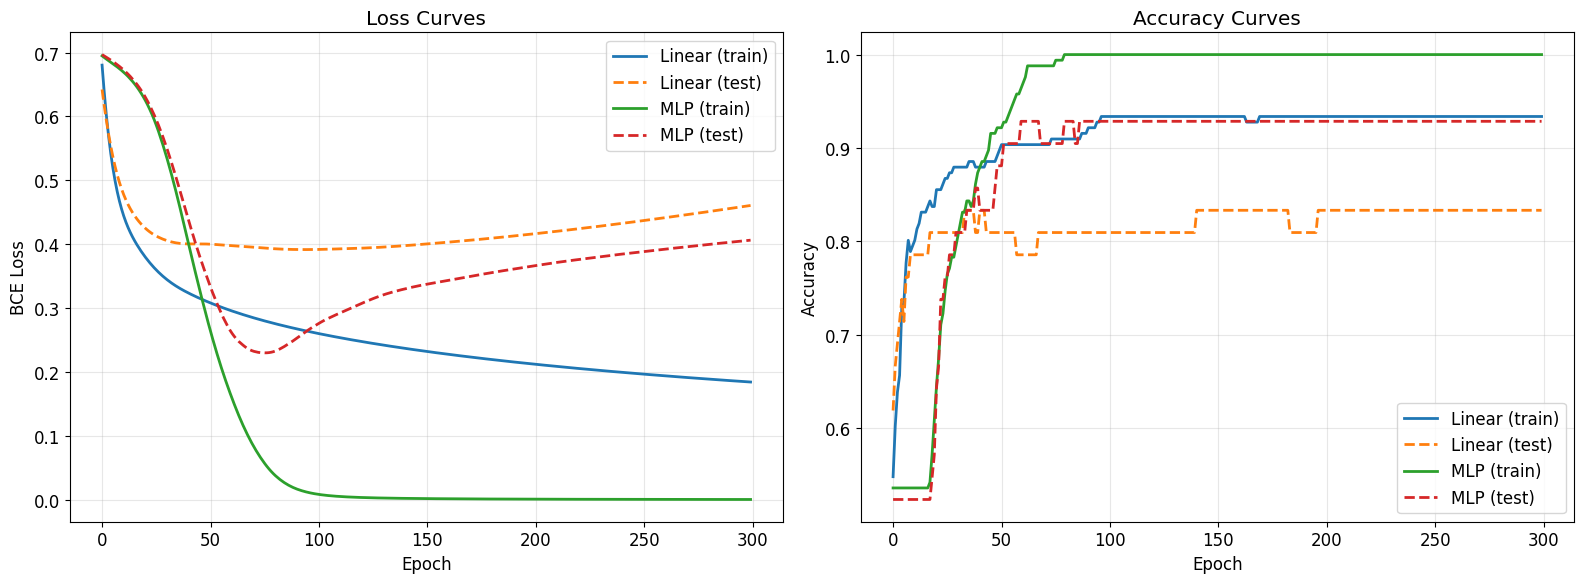


Model            Train Acc   Test Acc
Linear              0.9337     0.8333
MLP                 1.0000     0.9286


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss curves
axes[0].plot(linear_history['train_losses'], label='Linear (train)', linewidth=2)
axes[0].plot(linear_history['test_losses'], label='Linear (test)', linewidth=2, linestyle='--')
axes[0].plot(mlp_history['train_losses'], label='MLP (train)', linewidth=2)
axes[0].plot(mlp_history['test_losses'], label='MLP (test)', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(linear_history['train_accs'], label='Linear (train)', linewidth=2)
axes[1].plot(linear_history['test_accs'], label='Linear (test)', linewidth=2, linestyle='--')
axes[1].plot(mlp_history['train_accs'], label='MLP (train)', linewidth=2)
axes[1].plot(mlp_history['test_accs'], label='MLP (test)', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curves')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print(f"{'Model':<15} {'Train Acc':>10} {'Test Acc':>10}")
print(f"{'='*50}")
print(f"{'Linear':<15} {linear_history['train_accs'][-1]:>10.4f} {linear_history['test_accs'][-1]:>10.4f}")
print(f"{'MLP':<15} {mlp_history['train_accs'][-1]:>10.4f} {mlp_history['test_accs'][-1]:>10.4f}")
print(f"{'='*50}")


### ✏️ Quick Check

- Did your MLP beat the linear model? By how much?
- If it didn't, or the improvement is small, what might you change?
- Look at the train vs. test accuracy gap — is your model overfitting?

You'll have a chance to iterate on your architecture in Part 6.


---
## Part 5: PCA Decision Boundary Visualization

The Sonar data lives in 60 dimensions — we can't directly visualize decision boundaries. But we *can* project to 2D using PCA and see how each model carves up that projected space.

**Important caveat:** PCA projections lose information. The decision boundary in 2D is an approximation of what the model does in 60D. But it still gives valuable intuition.


In [14]:
# Fit PCA on training data
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

print(f"Variance explained by 2 components: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")


Variance explained by 2 components: 38.60%
  PC1: 20.83%
  PC2: 17.77%


In [15]:
def plot_decision_boundary_pca(model, X_train_full, X_train_2d, y_train, 
                               pca, scaler, title, ax):
    """
    Plot decision boundary in PCA space.
    
    Strategy: create a grid in PCA space, inverse-transform to 60D,
    run through the model, and plot the predictions.
    """
    # Create grid in PCA space
    x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Inverse PCA: go from 2D back to 60D
    # This is an approximation (we lose the other 58 components)
    grid_2d = np.c_[xx.ravel(), yy.ravel()]
    grid_60d = pca.inverse_transform(grid_2d).astype(np.float32)
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        grid_tensor = torch.tensor(grid_60d)
        predictions = model(grid_tensor).numpy().reshape(xx.shape)
    
    # Plot
    ax.contourf(xx, yy, predictions, levels=np.linspace(0, 1, 11),
                cmap='RdYlBu_r', alpha=0.6)
    ax.contour(xx, yy, predictions, levels=[0.5], colors='black', 
               linewidths=2, linestyles='--')
    
    # Plot data points
    mines = y_train == 1
    rocks = y_train == 0
    ax.scatter(X_train_2d[mines, 0], X_train_2d[mines, 1], 
               c='red', marker='o', edgecolors='black', s=60, label='Mine', zorder=5)
    ax.scatter(X_train_2d[rocks, 0], X_train_2d[rocks, 1], 
               c='blue', marker='s', edgecolors='black', s=60, label='Rock', zorder=5)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title)
    ax.legend()


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plot_decision_boundary_pca(
    linear_model, X_train, X_train_2d, y_train,
    pca, scaler, 'Linear Classifier', axes[0]
)

plot_decision_boundary_pca(
    mlp_model, X_train, X_train_2d, y_train,
    pca, scaler, 'Your MLP', axes[1]
)

plt.suptitle('Decision Boundaries in PCA Space (Training Data)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### ✏️ Think-Pair-Share: Reading the Decision Boundaries

1. How does the linear model's decision boundary compare to the MLP's? (Hint: look at the *shape* of the boundary.)
2. The dashed black line is the decision boundary (ŷ = 0.5). Which model's boundary is more complex?
3. Does the MLP's more complex boundary always mean it's better? When might a simpler boundary be preferable?
4. Remember: this is a PCA projection — we're only seeing 2 of 60 dimensions. How might the full 60D boundaries differ from what we see here?


---
## Part 6: Architecture Exploration (Minimum 5 Experiments)

Now the real work begins. You must run **at least 5 different MLP architectures** on the Sonar dataset, logging each to MLflow. Your goal is to understand how architecture choices affect performance.

**Things to vary across your experiments:**
- **Depth:** Try 1 hidden layer, 2 hidden layers, 3+ hidden layers
- **Width:** Try narrow layers (8-16 neurons) vs. wide layers (64-256 neurons)
- **Activation functions:** Try ReLU vs. Sigmoid in hidden layers
- **Learning rate:** Does the optimal LR change with architecture?
- **Any other ideas** you have (combinations of the above, etc.)

**Requirements:**
- Each experiment must be a **separate MLflow run** with a descriptive `model_name`
- Log the `architecture` string (e.g., `"60-128-64-1"`) so your report table is clear
- Log the `activation` (e.g., `"ReLU"`, `"Sigmoid"`, `"mixed"`)

**Tips:**
- Change one thing at a time so you can attribute differences
- Use `torch.manual_seed(42)` before each run for fair comparison
- Don't forget: you can check `mlflow ui` at any point to see your results so far

Use the cells below for your experiments. Add more cells as needed.


In [ ]:
# Experiment 1: [describe what you're testing]

# YOUR CODE HERE


In [ ]:
# Experiment 2: [describe what you're testing]

# YOUR CODE HERE


In [ ]:
# Experiment 3: [describe what you're testing]

# YOUR CODE HERE


In [ ]:
# Experiments 4, 5, ... : [add more cells as needed]

# YOUR CODE HERE


### ✏️ Quick Check Before Moving On

Before continuing, run `mlflow ui` in your terminal and verify you can see **at least 5 experiment runs** (plus the linear baseline). If you can't, go back and make sure each training call has `log_to_mlflow=True` (the default).


---
## Part 7: Reality Check — Is a Neural Network the Right Tool?

We've been comparing a linear model to an MLP. The MLP wins. But we should ask a harder question: **is a neural network even the right approach for 208 samples with 60 features?**

In practice, experienced ML practitioners would almost certainly try tree-based methods (Random Forest, Gradient Boosted Trees) on a small tabular dataset before reaching for a neural network. These methods:
- Handle small datasets well (they don't need thousands of samples)
- Naturally capture feature interactions (splits on one feature can depend on another)
- Are less prone to overfitting on small data
- Require less hyperparameter tuning

Let's find out if that conventional wisdom holds here.

### TODO: Train a Random Forest and compare to your neural networks


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train a Random Forest on the same train/test split
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_train_acc = accuracy_score(y_train, rf.predict(X_train))
rf_test_acc = accuracy_score(y_test, rf.predict(X_test))

print(f"Random Forest - Train Acc: {rf_train_acc:.4f}, Test Acc: {rf_test_acc:.4f}")


In [ ]:
# Quick comparison: your best MLP vs. Linear vs. Random Forest
n_params = sum(p.numel() for p in mlp_model.parameters())

print(f"{'='*60}")
print(f"{'Model':<25} {'Train Acc':>12} {'Test Acc':>12}")
print(f"{'='*60}")
print(f"{'Linear Classifier':<25} {linear_history['train_accs'][-1]:>12.4f} {linear_history['test_accs'][-1]:>12.4f}")
print(f"{'Your First MLP':<25} {mlp_history['train_accs'][-1]:>12.4f} {mlp_history['test_accs'][-1]:>12.4f}")
print(f"{'Random Forest':<25} {rf_train_acc:>12.4f} {rf_test_acc:>12.4f}")
print(f"{'='*60}")
print(f"\n(Your full experiment comparison is in Part 8 via MLflow)")


### ✏️ Think-Pair-Share: The Right Tool for the Job

1. How does the Random Forest compare to your MLP? To the linear model?
2. The Random Forest required **zero architecture decisions** (no hidden sizes, no activation functions, no learning rate tuning). What does this tell you about when neural networks are worth the extra effort?
3. Neural networks shine on **large datasets** with **complex structure** (images, text, audio). Why might they struggle relative to tree methods on small, tabular datasets like this one?
4. If someone handed you a new dataset with 200 samples and 50 features, what would you try *first*? What would make you reach for a neural network instead?

### The Takeaway

This lab wasn't about finding the best model for the Sonar dataset — it was about understanding **what nonlinear models can do that linear models can't.** The MLP's advantage over the linear classifier is real and conceptually important. But choosing the right tool for the job is just as important as understanding how each tool works. As you learn CNNs, RNNs, and Transformers in the coming weeks, you'll see the kinds of problems where neural networks aren't just competitive — they're the only game in town.


---
## Part 8: Experiment Report (Required)

Every experiment you ran has been automatically logged to MLflow. Now you'll pull that data, visualize it, and write up your findings.

### Step 1: Pull your experiment data


In [ ]:
# Pull all runs from our experiment into a pandas DataFrame
runs_df = mlflow.search_runs(
    experiment_names=["lab4-sonar-classification"],
    order_by=["metrics.final_test_acc DESC"]
)

# Display the key columns
comparison = runs_df[[
    "run_name",
    "params.architecture", 
    "params.activation",
    "params.learning_rate",
    "params.n_parameters",
    "metrics.final_train_acc",
    "metrics.final_test_acc"
]].copy()

comparison.columns = ["Model", "Architecture", "Activation", "LR", "Params", "Train Acc", "Test Acc"]
print("All experiments, ranked by test accuracy:\n")
print(comparison.to_string(index=False))


In [ ]:
# Save the comparison table as a CSV artifact in MLflow
comparison.to_csv("experiment_comparison.csv", index=False)

# Also log it as an artifact in a summary run
with mlflow.start_run(run_name="Experiment Summary"):
    mlflow.log_artifact("experiment_comparison.csv")
    
    # Log the best test accuracy across all runs
    best_idx = comparison["Test Acc"].astype(float).idxmax()
    mlflow.log_metric("best_test_acc", float(comparison.loc[best_idx, "Test Acc"]))
    mlflow.log_param("best_model", comparison.loc[best_idx, "Model"])

print("Summary logged to MLflow and saved to experiment_comparison.csv")


### Step 2: Visualize the comparison


In [ ]:
# Bar chart comparing all models
fig, ax = plt.subplots(figsize=(12, 6))

models = comparison["Model"].values
train_accs = comparison["Train Acc"].astype(float).values
test_accs = comparison["Test Acc"].astype(float).values

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_accs, width, label='Train Accuracy', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy', color='coral', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('Experiment Comparison: All Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0.5, 1.05)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("experiment_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("Chart saved to experiment_comparison.png")


### Step 3: Research and Write Your Report

Before writing, do some quick research on MLP best practices for small datasets. Some starting points:
- What do practitioners recommend for choosing hidden layer sizes?
- What is the role of regularization (dropout, weight decay) on small datasets?
- How does the ratio of parameters to training samples affect generalization?

Write **2-3 paragraphs** in the cell below covering:

1. **Your experiments and results:** Which architectures did you try? Which performed best and worst? What patterns did you notice as you changed depth, width, and activation functions? Reference specific numbers from your MLflow comparison table.

2. **The Random Forest reality check:** How did your best MLP compare to the Random Forest from Part 7? What does this tell you about when neural networks are the right tool vs. when simpler methods suffice? Why might tree-based methods outperform neural networks on small tabular datasets?

3. **Why certain architectures worked better:** Drawing on both your experimental results and your research, explain why some architectures outperformed others. Consider the tradeoffs between model capacity and overfitting, the role of activation functions in gradient flow, and what "too deep" or "too wide" means for a dataset of this size.


### YOUR REPORT HERE

[Write 2-3 paragraphs here. Cite specific accuracy numbers from your experiments. Reference what you learned from your research on best practices.]


---
## Submission Checklist

- [ ] Part 2: Linear classifier trains and reports accuracy
- [ ] Part 3: Your first MLP defined and trained
- [ ] Part 4: Loss curves and accuracy comparison (linear vs. your MLP)
- [ ] Part 5: PCA decision boundary plots generated
- [ ] Part 6: **At least 5 architecture experiments** completed and logged to MLflow
- [ ] Part 7: Random Forest comparison completed with discussion
- [ ] Part 8: Experiment report completed
  - [ ] MLflow comparison table generated
  - [ ] Bar chart of all experiments
  - [ ] **2-3 paragraph written report** with specific results, RF comparison, and research-backed analysis
- [ ] AI transcript included (if applicable)
- [ ] Committed and pushed to GitHub Classroom
